In [1]:
import os
import sys
from pathlib import Path

import anndata as ad
import cv2 as cv
import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
from joblib import Parallel, delayed
from matplotlib.pyplot import rc_context
from skimage import exposure, io
from skimage.util import img_as_ubyte
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tqdm.notebook import tqdm, trange
from matplotlib.patches import Patch

sc.settings.verbosity = 3

In [2]:
p_dir = (Path().cwd().parents[0]).absolute()
data_dir = p_dir / "data"

In [3]:
%load_ext autoreload
%autoreload 2

module_path = str(p_dir / "src")

if module_path not in sys.path:
    sys.path.append(module_path)

import scanorama
import utils as my_utils

In [4]:
experiment = "Tonsil"
cores=['DonorA', 'DonorE']
datasets = [f'{core}_{i}' for core in cores for i in range(1,7)]

# Load data

In [5]:
import palettable
heatmap_cmp = palettable.cmocean.diverging.Balance_20.mpl_colormap


In [6]:
def read_props(dataset, experiment):
    df_morph = pd.read_csv(data_dir / "props" / f"morphology_IMC_{experiment}_{dataset}.csv")
    df_intensity_IMC = pd.read_csv(data_dir / "props" / f"intensity_IMC_{experiment}_{dataset}.csv")
    df_intensity_TS = pd.read_csv(data_dir / "props" / f"intensity_TS_{experiment}_{dataset}_auto.csv")

    return df_morph, df_intensity_IMC, df_intensity_TS

In [7]:
adatas = []
df_sums = []
for dataset in datasets:
    try:
        df_morph, df_intensity_IMC, df_intensity_TS = read_props(dataset, experiment)
        print(f'Sucessfully read dataset {dataset}') 
    except:
        print(f'{dataset} cannot be read') 
        continue
    try:
        df_intensity_TS.drop(['Rest', 'Total'], axis=1, inplace=True)
    except:
        pass
    df_intensity_TS.iloc[:, 1:] = df_intensity_TS.iloc[:, 1:].multiply(
        df_morph["area"], axis=0
    )
    data_all = df_intensity_TS.iloc[:, 1:].values
    # data_all_norm = (data_all+0.1)/(np.percentile(data_all,50,axis=1,keepdims=True)+0.1)
    # data_all_norm = MinMaxScaler().fit_transform(data_all)
    # df_intensity_TS.iloc[:, 1:] = data_all_norm
    
    # Merge TS and IMC data
    df = df_intensity_TS
    df.set_index("Id", inplace=True)
    df_sums.append(df.sum(axis=0))
    
    # Put to adata format
    adata = sc.AnnData(df.values)
    adata.var_names = df.columns.tolist()
    adata.obs["Cell"] = df.index.tolist()
    adata.obs["Dataset"] = dataset
    adata.obs["Core"] = dataset.split("_")[0]
    adata.obsm["spatial"] = df_morph[["centroid-0", "centroid-1"]].to_numpy()
    sc.pp.normalize_total(adata, target_sum=1e4)
    # sc.pp.log1p(adata)
    # sc.pp.scale(adata)
    adatas.append(adata)
adata = ad.concat(adatas, join="inner")

Sucessfully read dataset DonorA_1
normalizing counts per cell
    finished (0:00:00)


C:\Users\thu71\AppData\Local\Temp/ipykernel_27840/3027073324.py:28: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = sc.AnnData(df.values)


Sucessfully read dataset DonorA_2
normalizing counts per cell
    finished (0:00:00)
Sucessfully read dataset DonorA_3
normalizing counts per cell
    finished (0:00:00)
Sucessfully read dataset DonorA_4
normalizing counts per cell
    finished (0:00:00)
Sucessfully read dataset DonorA_5
normalizing counts per cell
    finished (0:00:00)
DonorA_6 cannot be read
Sucessfully read dataset DonorE_1
normalizing counts per cell
    finished (0:00:00)
Sucessfully read dataset DonorE_2
normalizing counts per cell
    finished (0:00:00)
Sucessfully read dataset DonorE_3
normalizing counts per cell
    finished (0:00:00)
Sucessfully read dataset DonorE_4
normalizing counts per cell
    finished (0:00:00)
Sucessfully read dataset DonorE_5
normalizing counts per cell
    finished (0:00:00)
Sucessfully read dataset DonorE_6
normalizing counts per cell
    finished (0:00:00)


C:\Users\thu71\Anaconda3\envs\new_codex\lib\site-packages\anndata\_core\anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [8]:
df_sum = pd.concat(df_sums, axis=1).mean(axis=1)
mz_qc = df_sum[(df_sum > 70000)].index.tolist()

In [9]:
len(mz_qc)

146

In [10]:
adata = adata[:, mz_qc]

## Get literature lut

In [11]:
SIMS_masses = adata.var_names

In [12]:
# Read litterature lut
file_path = data_dir / "metadata" / 'Putative_annotation_09012022.xlsx'
df = pd.read_excel(file_path)
lum = df['m/z'].to_numpy()

# get matched table by looking at difference with error
error = 0.4
matched_dfs = []
for mz in SIMS_masses.astype(float):
    if mz < 1.1:
        continue
    diff = lum-mz
    matched = df[abs(diff)<error]
    if len(matched) > 0:
        matched.loc[:,'SIMS mz'] = mz
        matched_dfs.append(matched)
    else:
        matched = pd.DataFrame([['', '', '', '', mz]], columns=df.columns.tolist() + ['SIMS mz'])
        matched_dfs.append(matched)
matched = pd.concat(matched_dfs)

C:\Users\thu71\Anaconda3\envs\new_codex\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


In [13]:
# Get all info from litterature excel
SIMS_masses_subset = np.array(matched['SIMS mz'].to_list(), dtype=float).astype(str)
SIMS_masses_subset = pd.Index(SIMS_masses_subset)

SIMS_name_subset = np.array(matched['Molecules'].to_list()).astype(str)
SIMS_name_subset = pd.Index(SIMS_name_subset)

SIMS_nm_subset = SIMS_masses_subset + 'm/z ' + SIMS_name_subset

SIMS_type_subset = np.array(matched['Type'].to_list()).astype(str)
SIMS_type_subset = pd.Index(SIMS_type_subset)

print(f"Number of matched m/z: {len(SIMS_masses_subset)}")

Number of matched m/z: 145


In [14]:
adata_all = adata.copy()
adata = adata[:, SIMS_masses_subset]
adata.var_names = SIMS_nm_subset

In [15]:
# Read Protein clustering info
path = data_dir / "adata" / f"{experiment}_GC_CN.h5ad"
adata_CN = ad.read_h5ad(path)

In [16]:
# Read Protein clustering info
path = data_dir / "adata" / f"{experiment}_GC.h5ad"
adata_IMC_all = ad.read_h5ad(path)

# Competition analysis

In [17]:
type_dict = {'0': 'Other',
            '1': 'GC B-cell',
            '2': 'TFH', 
            '3': 'Other',
            '4': 'GC B-cell',
            '5': 'GC B-cell',
            '6': 'FDC',
            '7': 'Other',
            '8': 'Other',
            '9': 'Other',
            }

In [18]:
adata_IMC_all.obs['Region'] = (
    adata_IMC_all.obs['leiden']
    .map(type_dict)
    .astype("category")
)
adata_IMC_all.uns['Region_colors'] = adata_CN.uns['CN_colors'][:len(np.unique(adata_IMC_all.obs['Region']))]

In [19]:
adata.obs["Region"] = adata_IMC_all.obs["Region"]
adata.uns["Region_colors"] = adata_IMC_all.uns["Region_colors"]
adata.obsm["spatial"] = adata_IMC_all.obsm["spatial"]

## Get NN indices

In [152]:
from sklearn.neighbors import NearestNeighbors
from kneed import KneeLocator
from sklearn.cluster import MiniBatchKMeans
from matplotlib.ticker import MaxNLocator
from skimage import morphology, measure, exposure
from scipy import ndimage


def get_NN(adata, n):
    data = adata.obsm["spatial"]
    # fit = NearestNeighbors(n_neighbors=n + 1).fit(data)
    fit = NearestNeighbors(n_neighbors=n).fit(data)
    m = fit.kneighbors(data)
    # m = m[0][:, 1:], m[1][:, 1:]
    m = m[0], m[1] # Distances, Indices

    # sort_neighbors
    args = m[0].argsort(axis=1)
    add = (
        np.arange(m[1].shape[0]) * m[1].shape[1]
    )  # arange for number of elements with step of number of neighbors
    sorted_indices = m[1].flatten()[
        args + add[:, None]
    ]  # Extract indices in sorted order
    return sorted_indices


In [202]:
n_neighbors = 3
windows = []

for d in adata_IMC_all.obs.Core.unique():
    adata_subset = adata_IMC_all[adata_IMC_all.obs.Core == d, :]

    window = get_NN(adata_subset, n=n_neighbors)
    df_nn = pd.DataFrame(window, columns=['Cell Id', 'NN1', 'NN2'])
    df_nn['Donor'] = d

    windows.append(df_nn)

df_nn = pd.concat(windows)
df_nn = df_nn.reset_index()

In [203]:
df_nn

,index,Cell Id,NN1,NN2,Donor
0,0,0,90,1,DonorA_1
1,1,1,0,2,DonorA_1
2,2,2,48,68,DonorA_1
3,3,3,48,78,DonorA_1
4,4,4,44,49,DonorA_1
...,...,...,...,...,...
31151,3001,3001,2949,2962,DonorE_6
31152,3002,3002,2954,2962,DonorE_6
31153,3003,3003,2994,2937,DonorE_6
31154,3004,3004,2929,2907,DonorE_6


In [188]:
df_sims

,12.0m/z,13.0m/z,14.0m/z,16.0m/z,17.0m/z,24.0m/z,25.0m/z L-Frag,26.0m/z L-Frag,27.0m/z,32.0m/z,...,169.0m/z L-Frag,170.0m/z,171.0m/z FA(10:0),181.0m/z L-Frag,184.9m/z,186.0m/z,193.9m/z,200.9m/z,216.9m/z,253.3m/z FA(16:1)
0,103.517197,122.582733,47.535236,64.695633,53.822887,135.497528,197.590073,241.111969,52.632607,43.780476,...,41.381374,40.213203,40.815723,39.611523,72.275635,37.630314,40.643078,52.785236,38.222557,37.431519
1,103.886421,105.239258,35.220722,73.662376,52.297318,133.945236,186.543442,278.319733,57.122616,40.105938,...,36.775337,39.842369,37.335850,38.016987,94.315094,37.591263,33.647896,51.273335,34.845734,34.484573
2,99.623573,106.313393,34.662399,76.411819,51.201534,138.393860,184.115921,283.348022,56.883064,41.538227,...,40.233173,36.806976,35.896862,35.074841,92.578209,36.342728,36.819927,57.999901,38.565281,32.690624
3,98.701096,109.528259,40.620667,76.798416,48.891266,136.338852,184.282516,280.872009,56.090405,41.423885,...,39.209820,36.285641,38.607941,37.696983,90.030357,33.807911,34.004482,55.487614,36.007942,36.271126
4,94.178635,107.352707,39.278038,77.332283,49.965160,118.938728,178.221542,266.990570,52.652737,35.094704,...,39.830238,37.268021,37.559811,38.061546,88.786324,37.455265,36.246391,56.029068,38.205708,36.942055
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31151,89.534363,77.610138,37.010242,83.892021,54.131474,99.348587,132.238174,270.024902,55.541405,41.971294,...,41.352268,42.451168,43.536980,44.147800,78.834381,40.442566,38.789032,45.862354,41.066082,40.404285
31152,84.130150,80.738693,35.178429,87.762619,54.790279,111.791687,136.244476,274.174133,53.639423,46.727730,...,43.161366,42.850689,40.601311,39.440094,72.519989,38.848774,36.650639,48.219063,35.936520,39.942219
31153,93.503548,107.428360,43.917007,88.247635,57.136250,111.275833,149.014297,251.068939,53.159210,51.801830,...,43.547615,41.114899,39.972694,39.993523,68.835793,41.667934,40.669464,50.488045,48.749310,38.654636
31154,92.171417,110.529900,46.656162,81.677811,55.732635,106.648766,140.276794,245.735977,55.542763,47.462132,...,41.006618,41.479141,41.757908,39.446823,77.451889,40.820984,39.873756,56.050243,44.009109,42.593952


In [215]:
import collections 

labels = adata.obs["Region"].tolist()
info = collections.defaultdict(list)
ratios = []

for i, row in enumerate(df_nn.itertuples()):   
    nn1 = row.NN1
    nn2 = row.NN2
    
    info['Cell Type'].append(labels[i])
    info['NN1 Type'].append(labels[nn1])
    info['NN2 Type'].append(labels[nn2])
    info['Donor'].append(row.Donor)
    
    ratio = df_sims.iloc[i].div(df_sims.iloc[i]+df_sims.iloc[nn1]+df_sims.iloc[nn2])
    ratios.append(ratio.to_frame().T)

In [216]:
ratio = pd.concat(ratios)
ratio = ratio.reset_index(drop=True)

In [217]:
ratio

,12.0m/z,13.0m/z,14.0m/z,16.0m/z,17.0m/z,24.0m/z,25.0m/z L-Frag,26.0m/z L-Frag,27.0m/z,32.0m/z,...,169.0m/z L-Frag,170.0m/z,171.0m/z FA(10:0),181.0m/z L-Frag,184.9m/z,186.0m/z,193.9m/z,200.9m/z,216.9m/z,253.3m/z FA(16:1)
0,0.327779,0.343155,0.379069,0.310173,0.356377,0.343627,0.345505,0.310798,0.324845,0.339693,...,0.343434,0.329127,0.351657,0.335440,0.289426,0.340426,0.367780,0.336167,0.343102,0.337711
1,0.338362,0.314960,0.299959,0.342983,0.332423,0.328429,0.328277,0.346695,0.342794,0.319761,...,0.310629,0.340934,0.327368,0.337319,0.363914,0.336947,0.302832,0.316388,0.312144,0.329659
2,0.340824,0.326486,0.296868,0.353626,0.337452,0.343270,0.331713,0.343294,0.347633,0.320451,...,0.347362,0.340849,0.320671,0.324119,0.343845,0.335611,0.327534,0.334718,0.337637,0.317027
3,0.342546,0.327178,0.321255,0.357054,0.328304,0.343035,0.334019,0.349175,0.347089,0.320606,...,0.334513,0.331304,0.335436,0.338869,0.353149,0.318683,0.303738,0.334276,0.318533,0.335366
4,0.320281,0.307234,0.283953,0.356755,0.334266,0.324316,0.327840,0.351375,0.339648,0.300699,...,0.340301,0.324373,0.323688,0.321567,0.373156,0.325746,0.331578,0.332950,0.331101,0.336840
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31151,0.288725,0.292460,0.339676,0.303995,0.346543,0.256682,0.280594,0.310711,0.300776,0.291233,...,0.335248,0.360578,0.378910,0.377873,0.300973,0.371961,0.341744,0.284177,0.350109,0.355224
31152,0.277518,0.292107,0.323034,0.315401,0.343614,0.271509,0.279987,0.316051,0.289622,0.314823,...,0.340469,0.355486,0.353787,0.357870,0.284870,0.361163,0.335297,0.301655,0.321281,0.350212
31153,0.311963,0.329383,0.361885,0.358401,0.378547,0.279105,0.291446,0.309282,0.310850,0.356941,...,0.354794,0.346071,0.362714,0.351571,0.285719,0.364530,0.351134,0.320107,0.381425,0.338335
31154,0.311439,0.369988,0.412752,0.286381,0.344695,0.263156,0.287765,0.289633,0.287840,0.317005,...,0.338520,0.364323,0.368320,0.351189,0.290236,0.370522,0.354495,0.326153,0.353147,0.365392


In [218]:
df_info = pd.DataFrame(info)
df_info

,Cell Type,NN1 Type,NN2 Type,Donor
0,Other,FDC,Other,DonorA_1
1,Other,Other,Other,DonorA_1
2,Other,Other,Other,DonorA_1
3,Other,Other,Other,DonorA_1
4,Other,Other,Other,DonorA_1
...,...,...,...,...
31151,GC B-cell,Other,Other,DonorE_6
31152,GC B-cell,Other,Other,DonorE_6
31153,GC B-cell,Other,Other,DonorE_6
31154,Other,GC B-cell,GC B-cell,DonorE_6


In [219]:
df_all = pd.concat([df_info, ratio], axis=1)

In [220]:
cell_type = 'GC B-cell'
n_type = 'TFH'

df_subset = df_all[df_all['Cell Type'] == cell_type]
df_subset = df_subset[(df_subset['NN1 Type'] == n_type)]

C:\Users\thu71\Anaconda3\envs\new_codex\lib\site-packages\seaborn\matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


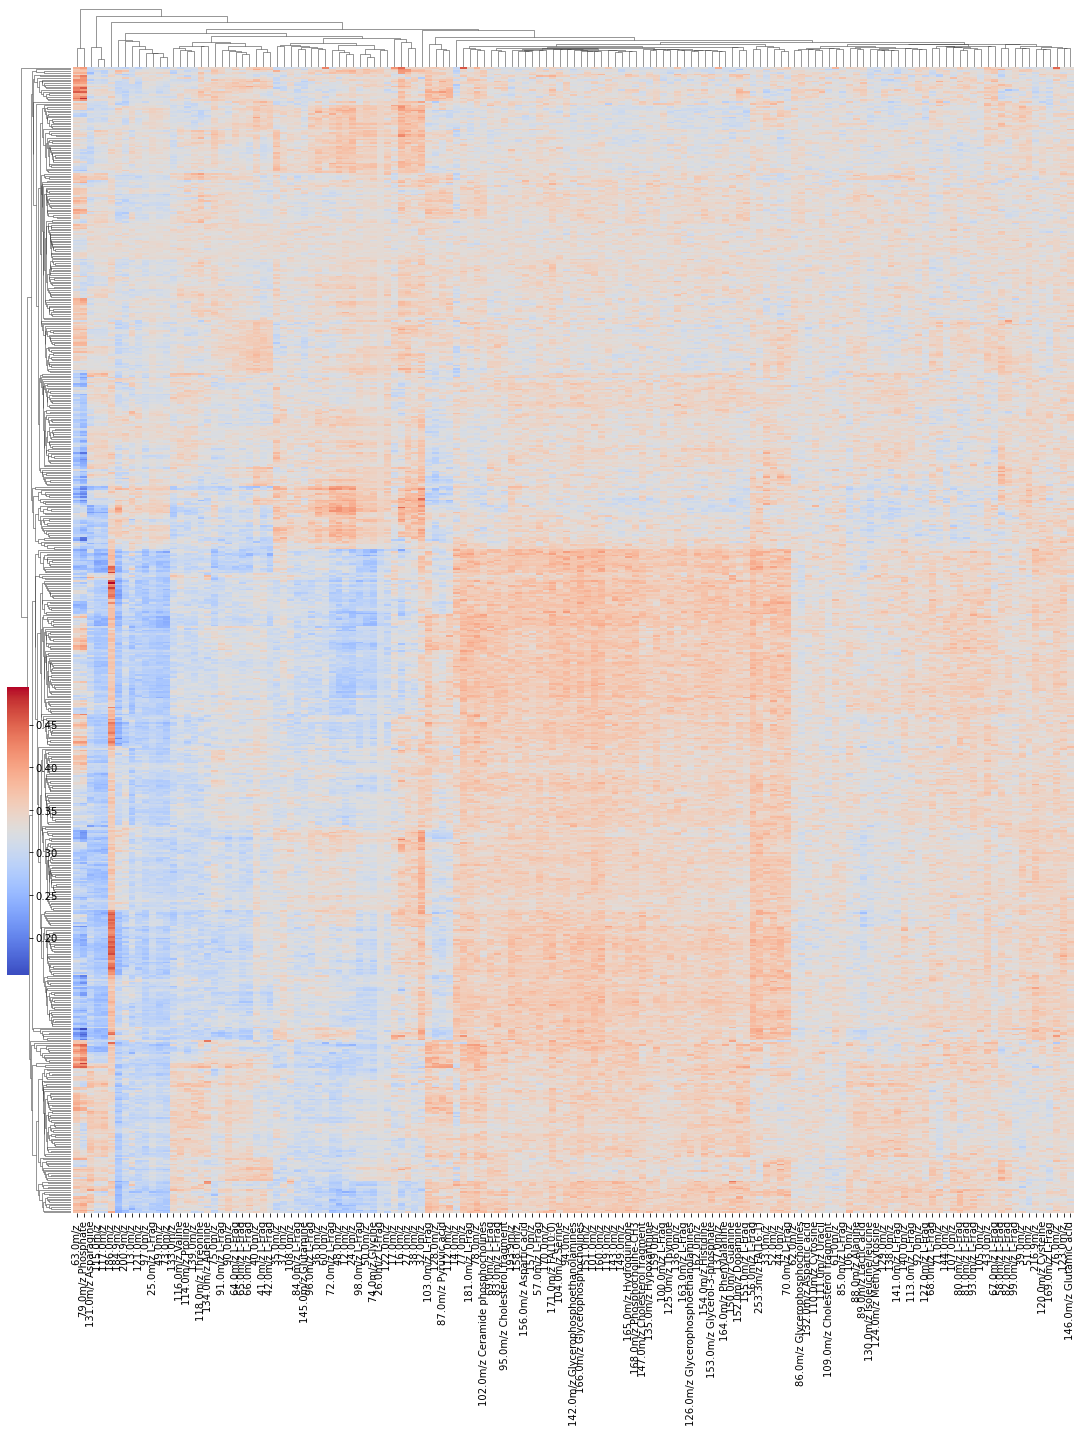

In [195]:
g = sns.clustermap(df_subset.iloc[:, 3:],
                   cmap='coolwarm', 
                   row_cluster=True,
                   col_cluster=True,
                   colors_ratio = (0.015, 0.01),
                   cbar_pos=(.0, .32, .02, .2), 
                   dendrogram_ratio=(.05, .05), 
                   figsize=(15, 20), 
                   yticklabels=False, 
                   xticklabels=True, )

# Plot specific interaction

In [222]:
from typing import List
import matplotlib
import skimage
from skimage import measure


def get_masks(mask_folder, dataset):
    """
    Function to get all mask from mask forlder
    """
    # Read masks
    masks = {}

    for (dirpath, dirnames, filenames) in os.walk(mask_folder):
        for name in sorted(filenames):
            if "tif" in name and dataset in name:
                filename = os.path.join(dirpath, name)
                img = skimage.io.imread(filename)
                condition = name.split(".")[0]
                masks[condition] = img
            else:
                continue
    return masks


def create_clustered_cell(mask, label2cell, my_cmap, **kwargs):
    img = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)

    for i, cells in tqdm(label2cell.items(), total=len(label2cell)):
        rows, cols = np.where(np.isin(mask, cells))
        img[rows, cols, :] = my_cmap[int(i)]

    return img


def get_contour(mask: np.ndarray) -> List[List[float]]:
    """
    Get contours of mask
    """
    contours = []
    for i in sorted(np.unique(mask)):
        if i == 0:
            continue
        contours.append(measure.find_contours(mask == i, 0.8)[0])

    return contours

In [223]:
experiment='tonsil'
masks = get_masks(data_dir / "masks", f"{experiment}")

In [224]:
colors = adata.uns["Region_colors"]
labels = np.unique(adata.obs.Region.tolist())

colors_rgb = []
for color in colors:
    colors_rgb.append(matplotlib.colors.hex2color(color))
colors_rgb = np.array(colors_rgb) * 255
colors_rgb = colors_rgb.astype(np.uint8)

In [225]:
# indices = df_subset.index.tolist() + df_nn.loc[df_subset.index.tolist()].NN1.tolist()
# indices = df_nn.loc[df_subset.index.tolist()].NN2.tolist()
# indices = df_subset.index.tolist()

In [226]:
# adata_cells = adata[indices]

DonorA_1


  0%|          | 0/4 [00:00<?, ?it/s]

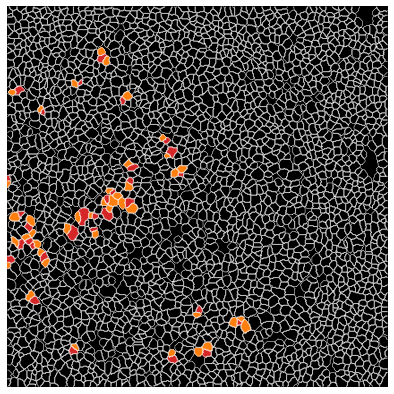

In [227]:
for dataset in datasets:
    print(dataset)
    adata_subset = adata[adata.obs.Dataset == dataset, :]
    try:
        mask = masks["_".join([experiment, dataset])]
        contours = get_contour(mask)
    except:
        continue
    
    df_fov = df_subset[df_subset.Donor == dataset]
    indices = df_fov.index.tolist() + df_nn.loc[df_fov.index.tolist()].NN1.tolist()
    
    adata_subset = adata_subset[indices]
    
    # Get label2cell dict
    label2cell = {}
    for i, l in enumerate(labels):
        cell_id = adata_subset[adata_subset.obs.Region == l].obs.Cell.to_list()
        label2cell[i] = cell_id

    img = create_clustered_cell(mask, label2cell, colors_rgb)

    fig, ax = plt.subplots(figsize=(7, 7))
    ax.imshow(img)
    for j, contour in enumerate(contours):
        ax.plot(contour[:, 1], contour[:, 0], linewidth=0.5, color="white")
    ax.axis("off")
    plt.show()
    
    break